In [1]:
import json
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from matplotlib.gridspec import GridSpec

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets import GeoBenchBENV2
from geobench_v2.datasets.normalization import SatMAENormalizer
from geobench_v2.datasets.visualization_util import visualize_effect_of_normalization

sns.set_palette("deep")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 12

# Define project root
PROJECT_ROOT = Path("../../")


%load_ext autoreload
%autoreload 2

# Understanding SatMAENormalizer in Detail

This notebook provides an in-depth explanation of the SatMAENormalizer used in GeoBench2. Generally, the way we normalize our input data can have significant impacts on training dynamics and performance. While in standard computer vision with normal RGB imagery normalization is usually straight forward since all imagery falls into a fixed [0, 255] range. However, in the Earth Observation (EO) domain, there exist a large variety of satellites that not only measure bands beyond the common RGB bands, but also do so in different ranges. One recent study about the impact of normalization on pretrained models specifically was done by [Corley et al. 2024](https://openaccess.thecvf.com/content/CVPR2024W/PBVS/papers/Corley_Revisiting_Pre-trained_Remote_Sensing_Model_Benchmarks_Resizing_and_Normalization_Matters_CVPRW_2024_paper.pdf), who show that normalization and resizing has a considerable effect on model performance of pretrained RGB ImageNet models which are often considered as baseline models.

One goal of GeoBenchV2 is to provide a set of normalization tools that easily let you experiment with different normalization schemes, inspect the effect of them, and find the best normalization scheme for different pretrained models. The `SatMAENormalizer` has been used for several different pretrained geospatial models, such as SatMAE, CROMA, and others. 


In this tutorial notebook, we will showcase the `SatMAENormalizer` module, which can be used to do two normalization schemes:
1. Standard Z-Score Normalization
2. First, clip the data to a desired range, and then apply Z-Score Normalization
3. First, clip the data to a desired range, then divide by the max value to obtain a [0,1] interval, followed by Z-Score Normalization

## Loading Real BigEarthNet V2 Data

First, let's load some actual Sentinel data from the BENV2 dataset. The `GeoBenchBENV2DataModule` holds all the imporant information that make up a dataset for experimentation purposes. The `data_normalizer` argument accepts a `torch.nn.Module` that will be applied on every sample loaded from the `__getitem__` method of the underlying dataset class. Since we want to just illustrate the effect of different normalization schemes, we will pass `nn.Identiy()` to return "raw" data that is unchanged.

BENV2 has two modalities: Sentinel 1 and Sentinel 2 data, that both have different number of bands, and different ranges of values.

In [2]:
band_order = GeoBenchBENV2.band_default_order

datamodule = GeoBenchBENV2DataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


## Load and Prepare Statistics for Normalization

In [3]:
stats_path = str(
    PROJECT_ROOT / "geobench_v2/generate_benchmark/dataset_stats/benv2/benv2_stats.json"
)

satmae_normalizer = SatMAENormalizer(stats_path, band_order, output_range="neg_one_one")
satmae_normalizer_two_stage = SatMAENormalizer(
    stats_path, band_order, output_range="zero_one", apply_second_stage=True
)

## How SatMAENormalizer Works

The `SatMAENormalizer` performs normalization in two main steps:

1. **Clipping Step**: Values are clipped to a predefined range (min/max values)
2. **Range Scaling**: The clipped values are then rescaled to a target range (typically [0,1])


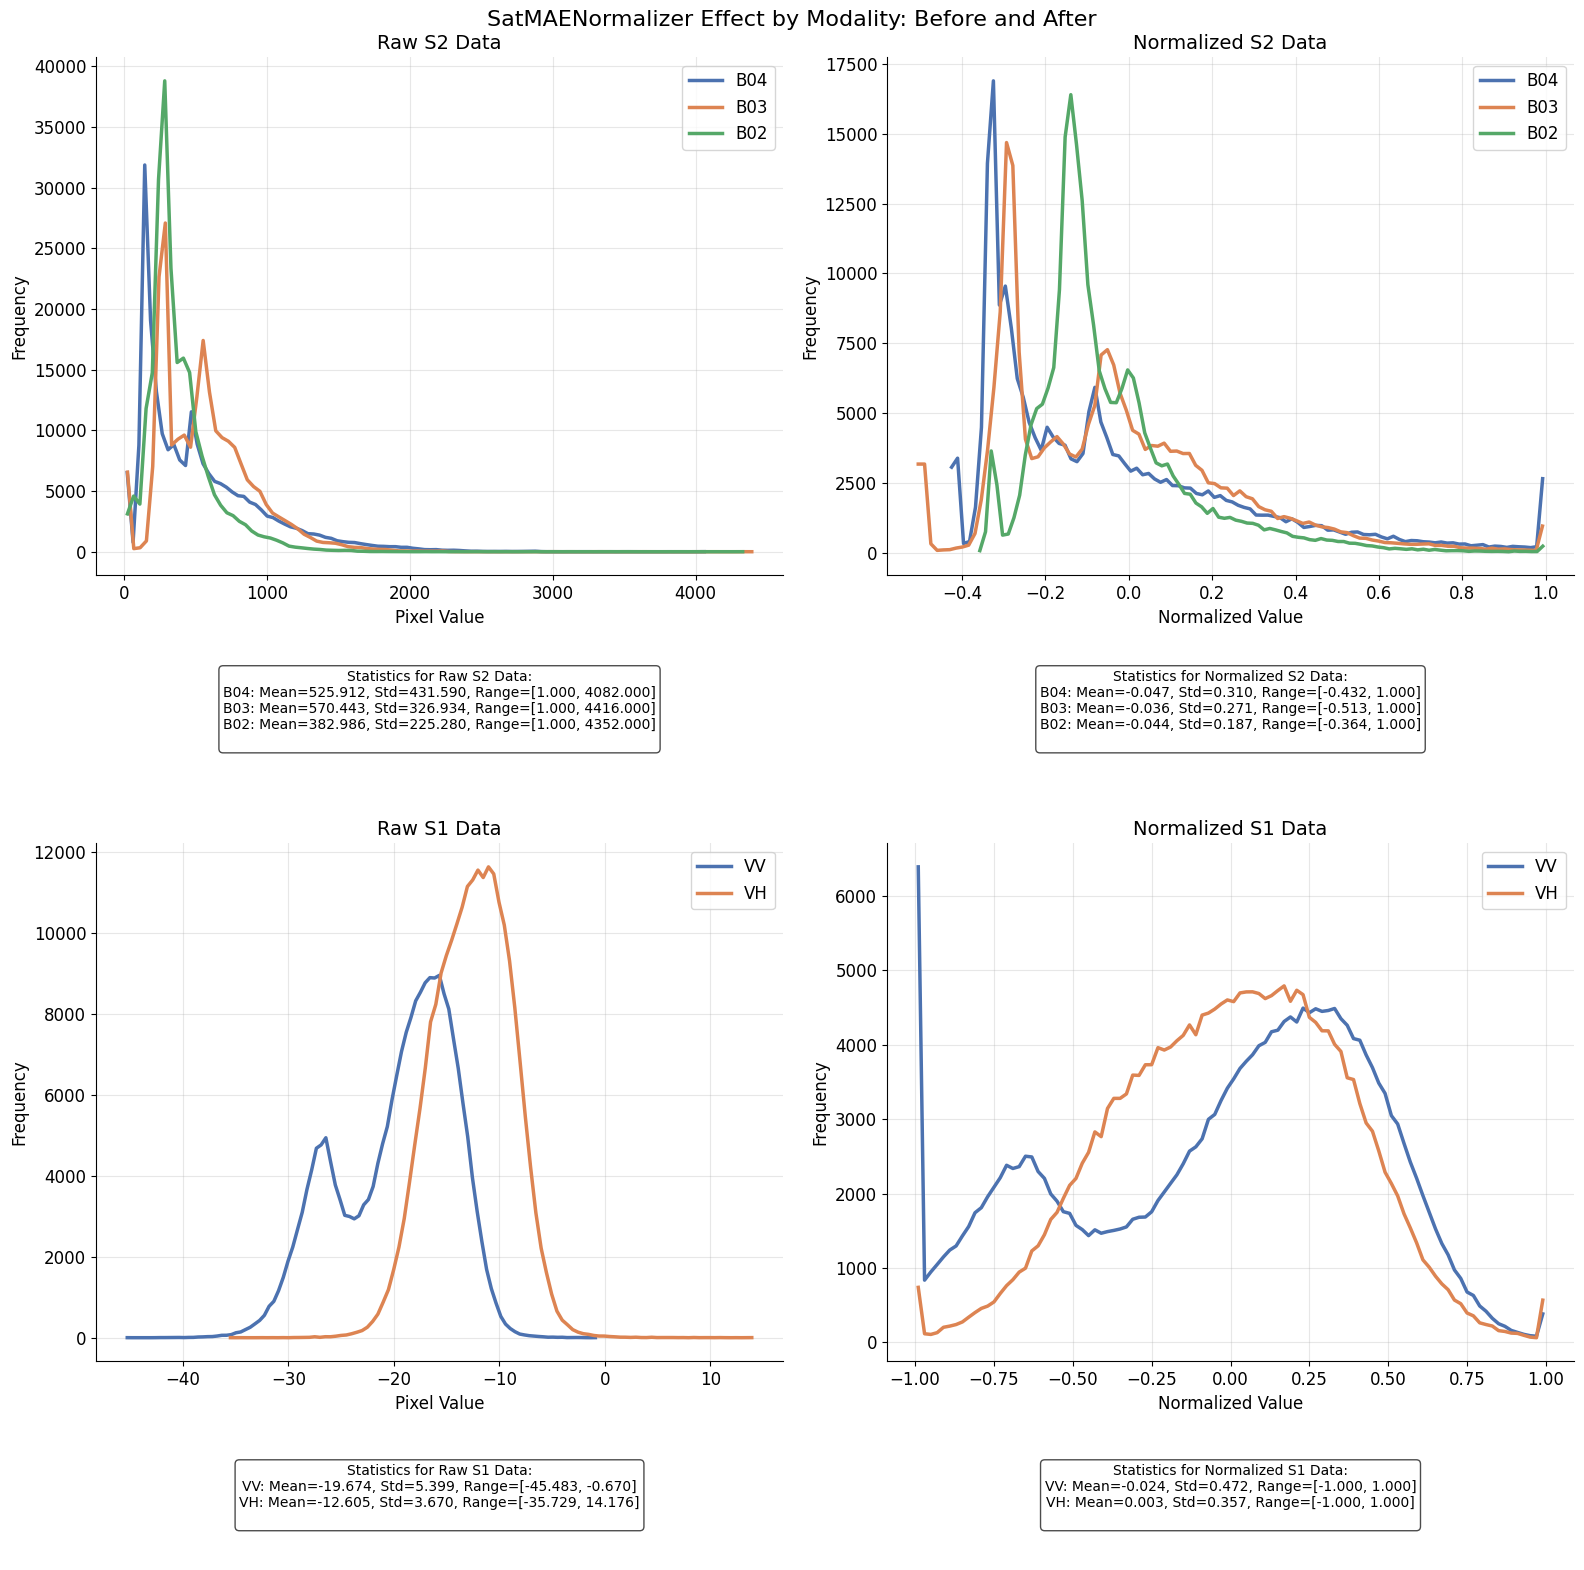

In [4]:
# Use the simplified visualization function
norm_fig, normalized_batch = visualize_effect_of_normalization(
    raw_batch, satmae_normalizer, datamodule
)

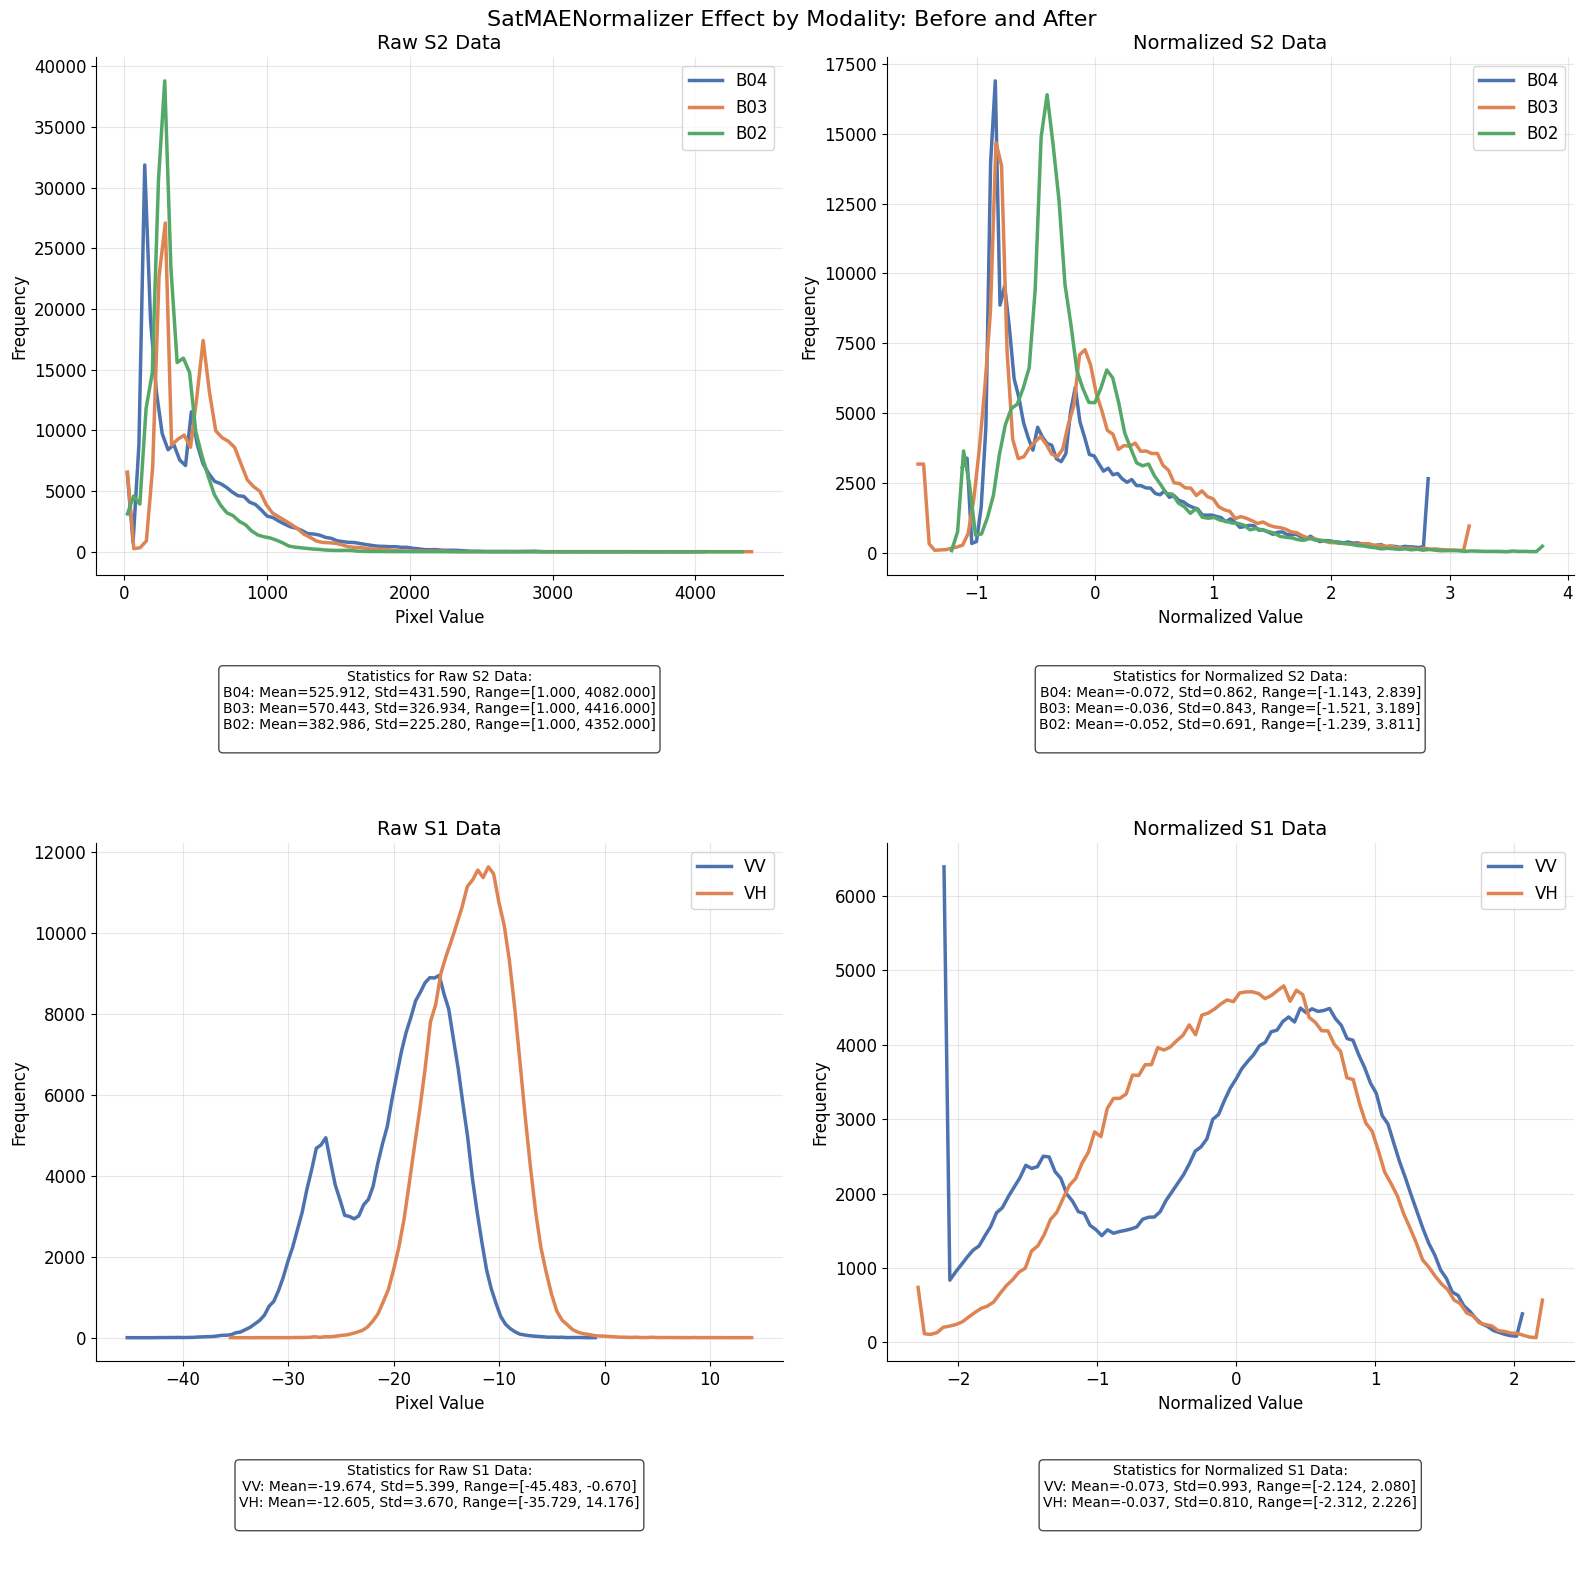

In [5]:
norm_fig, normalized_batch = visualize_effect_of_normalization(
    raw_batch, satmae_normalizer_two_stage, datamodule
)